# 1D Water Isotope Diffusion Model

Liam Kirkpatrick

Feb 15, 2024

IBIS project on water isotope diffusion

This model integrates added functions, including the ability to vary ice thickness and temperature over the course of the mdoel run.

### Import packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import math
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable # allows adding colorbar on line plot

### Define Forward Euler scheme algorithm for solving diffusion equation

Here I draw from: https://hplgit.github.io/fdm-book/doc/pub/diffu/pdf/diffu-4print.pdf, https://zsylvester.github.io/post/diffusion_equation/, and https://www.uni-muenster.de/imperia/md/content/physik_tp/lectures/ws2016-2017/num_methods_i/heat.pdf. However, I end up choosing to write my own function here.


In [2]:
def diffusion(t,z,z0,zmax,I,T,thin):
# function
#     Computes diffusion using a 1D euler method approach
# Inputs:
#     t    - vectors of time for the run (UNITS: years)
#     z    - vector of vertical (1D) grid spacing (UNITS: m)
#     z0   - boundary condition, upper side (UNITS: permille)
#     zmax - boundary condition, lower side (UNITS: permille)
#     I    - vector of inital condition (UNITS: permille)
#     T    - Diffusion coefficent (UNITS: m^2/s)
#     thin - vector of thinning of layers. 
# Outputs:
#     T    - matrix of results, where first axis is time and seccond axis is vertical grid (UNITS: permille)

    
    # find dt (convert to secconds)
    dt = (t[1]-t[0]) * 365.25 * 24 * 60 * 60
    
    # find number of timesteps and distance steps
    nt = len(t)
    nz = len(z)
        
    # create matrix of results. Set full of zeros for now
    ISO = np.zeros((nt,nz))
    
    # set first line of matrix to initial conditions, set edges to boundary conditions
    ISO[0,:] = I
    ISO[0,0] = z0
    ISO[0,-1] = zmax
    
    # loop through all timesteps (from 1:end). We don't need to run first timestep as that's the inital conditions
    for j in range(1,nt):
        
        # Calculate dz at this timestep. This might change due to thinning.
        dz = (z[1]-z[0]) * thin[j]
        
        # Calculate diffusion coefficent (following Gkinis et al., 2014)
        D = 9.2 * 10**(-4) * math.exp(-7186/T[j]) # units m^2/s
        
        # check stability
        if dt > (0.5*dz**2 / D):
            print("*******************************")
            print("*******************************")
            print("            UNSTABLE           ")
            print("*******************************")
            print("*******************************")
        
        # calculate diffusion number
        d = D * dt / (dz**2)
        
        # loop through all grid points (except left/right side)
        for i in range(1,nz-1):
            
            # solve for gridpoint at this time step
                # this draws on this point, the point above, and the point below at the prior timestep
            ISO[j,i] = ISO[j-1,i] + d * (ISO[j-1,i-1] - 2*ISO[j-1,i] + ISO[j-1,i+1])
            
        # set endpoints
        ISO[j,0] = z0
        ISO[j,-1] = zmax
        
    return(ISO)

### Define initial and boundary conditions, time vector, etc


In [3]:
# set time vector
years = 1*10**6
resolution = 5
t = np.linspace(0,years,round(years/resolution)+1)

# set boundary conditions (per mille)
z0 = -50
zmax = -50

# set (inital) space vector. Units of m. Ideal to keep AT LEAST 1cm resolution (so 100x).
meters = 1 # total depth range of sample
gridspace = 0.01 # model resultion, m
z = np.linspace(0,meters,round(meters/gridspace)+1) # make vector. Have to round number of samples to whole number.

# set inital conditions
I = np.ones(len(z)) * (z0+zmax)/2
# period of the sin wave (m)
period_sin = 0.4 # MUST BE EVENLY DIVIDABLE BY GRIDSPACE!
period_sin_gridpoints = round(period_sin/gridspace) + 1

# amplitude of sin wave (per mille)
sin_amp = 10
for i in range(period_sin_gridpoints):
    
    midpt = math.ceil(len(z)/2)
    index = midpt - math.floor(period_sin_gridpoints/2) + i
    
    I[index] = I[index] + sin_amp * math.sin(i/period_sin_gridpoints * 2*math.pi)

## Define vectors which change with time

This includes both temperature and the thickness of the ice.

In [4]:
# Define Demperature
# here you define the temperature at each timestep.
# You can do this however you want, as long as you end up with a vector that has the same number of timesteps as time
T = np.linspace(220,260,len(t))

# define thinning
# As above, do this however you want, but make sure to end up with a vector with the same number of elements as time.
thin0 = 1
thinend = 0.5
thin = np.linspace(thin0,thinend,len(t))


## Visualize Forcing Conditions

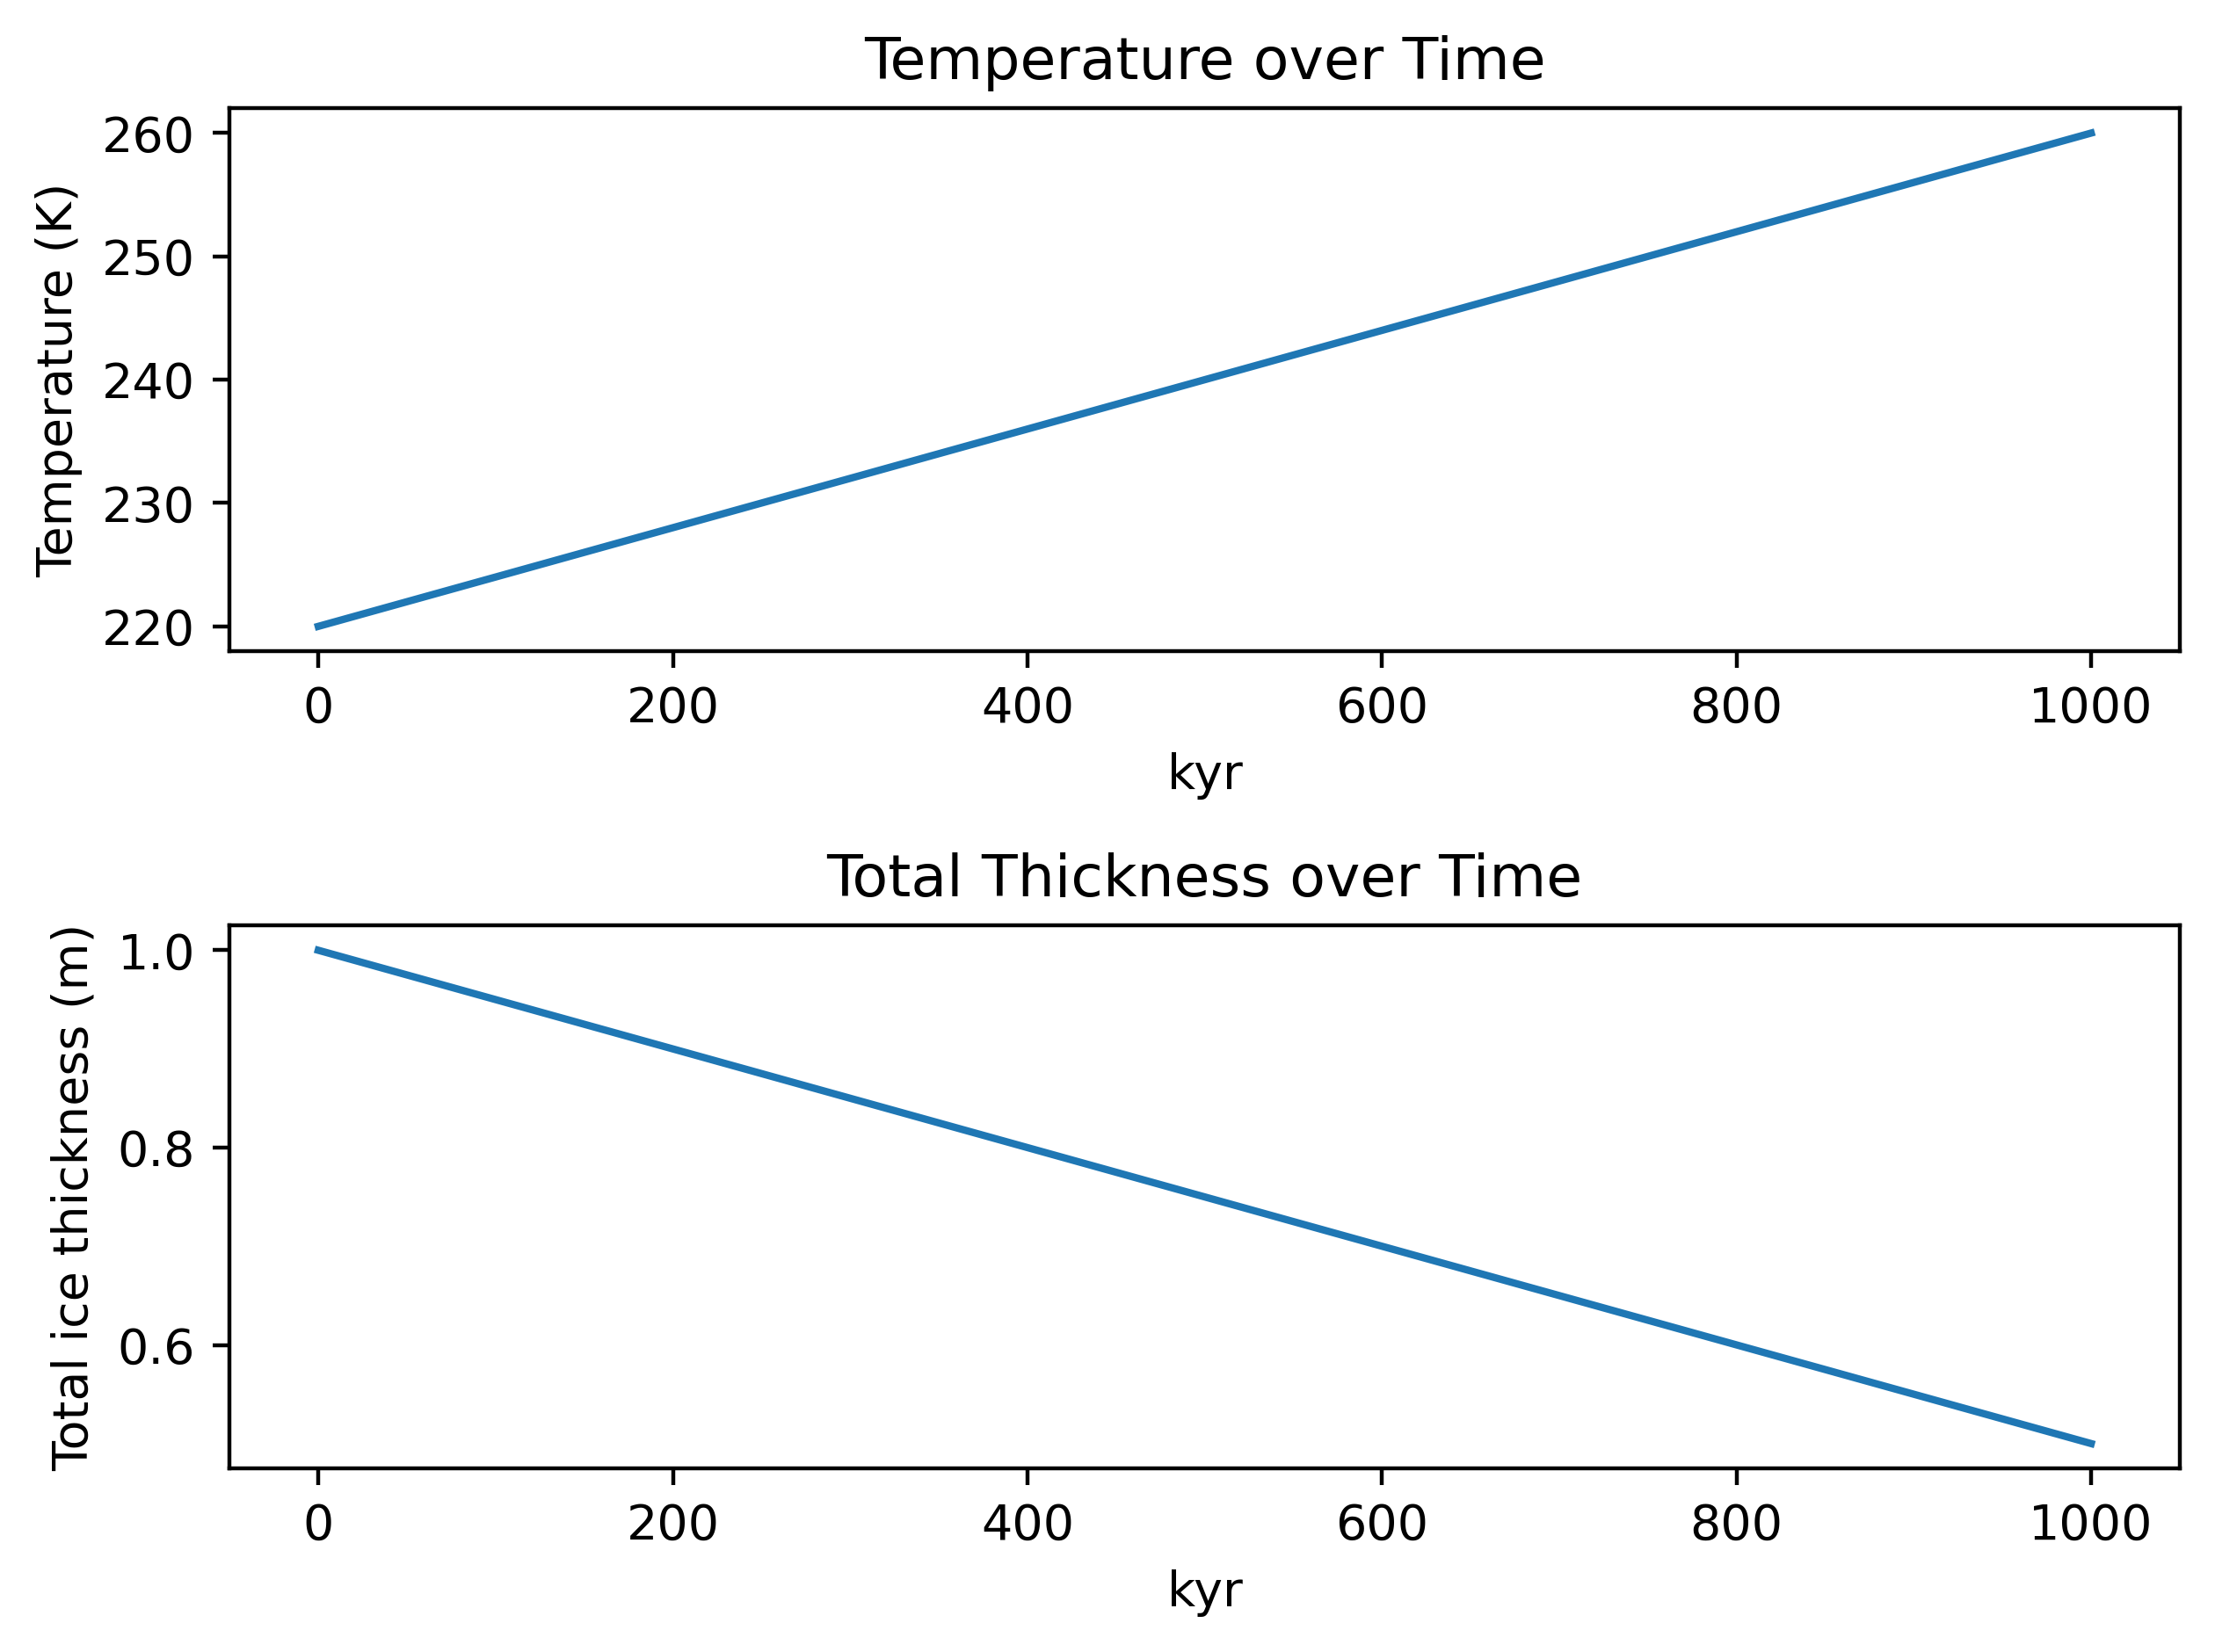

In [5]:
# make figure
fig, axs = plt.subplots(2,1,dpi=400)

# axis labels
axs[0].set_ylabel('Temperature (K)')
axs[1].set_ylabel('Total ice thickness (m)')
axs[0].set_xlabel('kyr')
axs[1].set_xlabel('kyr')
axs[0].set_title('Temperature over Time')
axs[1].set_title('Total Thickness over Time')

# plot curves (divide time by 1000 to plot in kyr)
axs[0].plot(t/1000,T)
axs[1].plot(t/1000,thin*meters)

# fix subplot spacing
plt.tight_layout()

### Run model temperature

In [6]:
run1 = diffusion(t,z,z0,zmax,I,T,thin)

### Plot Result

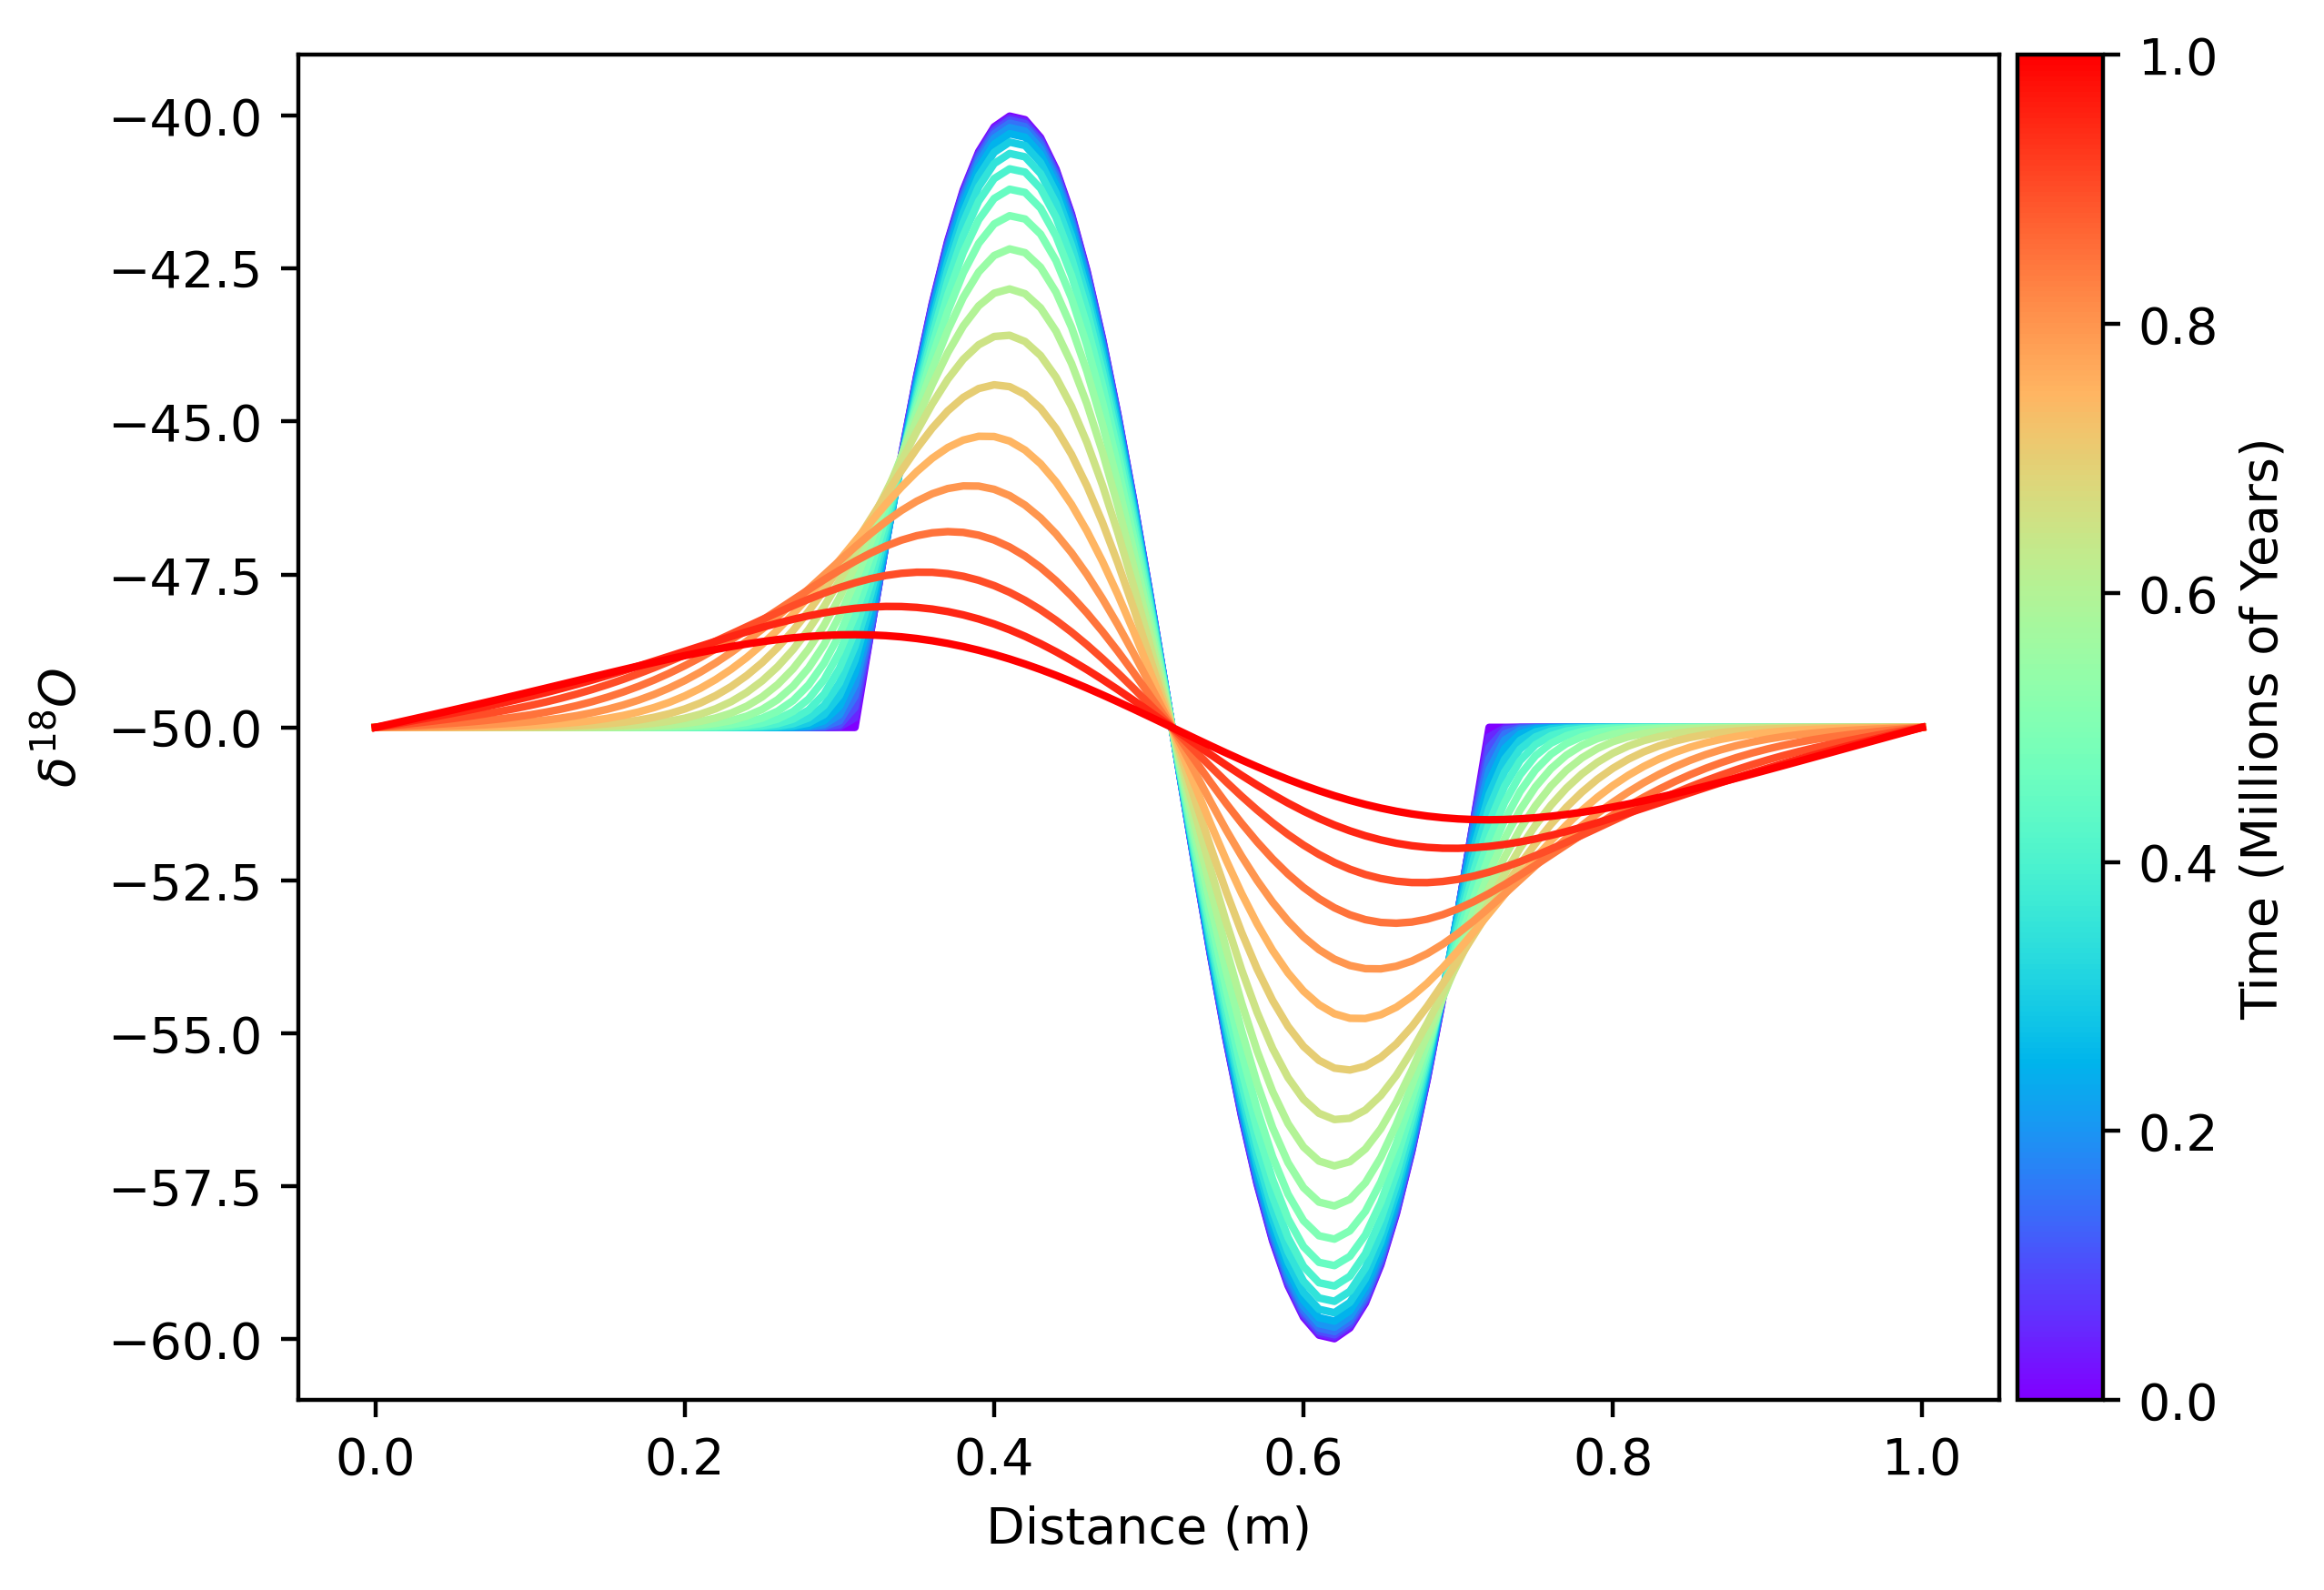

In [7]:
# make figure
fig, axs = plt.subplots(dpi=400)
axs.set_ylabel(r'$\delta^{18}O$')
axs.set_xlabel('Distance (m)')

# set colormap and add colorbar
norm = matplotlib.colors.Normalize(vmin=np.min(t)*10**-6,vmax=np.max(t)*10**-6)
cmap = matplotlib.colormaps.get_cmap('rainbow')
s_m = matplotlib.cm.ScalarMappable(cmap=cmap,norm=norm)
s_m.set_array([])
divider = make_axes_locatable(axs)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(s_m,cax=cax,label='Time (Millions of Years)')

# Plot all time steps
for i in range(0,len(t),10**4): # loop through all time steps
        
    # plot give time step. Shade by time. Ignore first/last point 
    axs.plot(z,run1[i,:],color=cmap(i/len(t)))